# Builduing Educational Applications Results

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
sys.path.append("../")
sys.path.append("../../")

In [4]:
import matplotlib.style as style
style.use('tableau-colorblind10')

# Generic utility functions

In [5]:
from src.utils.files import json2data
from src.utils.files import read_config
from copy import deepcopy
from warnings import warn


def yield_directories(config_name, test_run=False):
    config_dir = f"CODE_DIR/configs/experiments/{config_name}/"
    configs_path = os.listdir(config_dir)
    
    for conf_path in configs_path:
        config = read_config(os.path.join(config_dir, conf_path))
        # that one experiment config tells us where the results were saved 
        conf_name = config.name + "_test_run" if test_run else config.name 
        results_save_dir = os.path.join(config.save_dir, conf_name, "results")
        
        if not os.path.exists(results_save_dir) or not os.listdir(results_save_dir):
            warn(f"Experiment {config.name} has not finnished yet or failed.")
            continue 
            
        # This specific experiment is identified by the names of 
        # the important elements (e.g. agent or task)
        config_identifiers = {el: v["name"] for el, v in config.toDict().items() 
                              if type(v) == dict and 'name' in v}
                
        # should only be one 
        res_path = os.listdir(results_save_dir)[0]
        
        res = json2data(os.path.join(results_save_dir, res_path))
        
        yield res, config_identifiers

In [6]:
from collections import OrderedDict

agent_to_model = {
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0": "TinyLlama",
    'codellama/CodeLlama-7b-Instruct-hf': "CodeLlama",
    "HuggingFaceH4/zephyr-7b-alpha": "Zephyr-alpha",
    "HuggingFaceH4/zephyr-7b-beta": "Zephyr-beta",
    'meta-llama/Llama-2-7b-chat-hf': "Llama",
    'mistralai/Mistral-7B-Instruct-v0.2': "Mistral",
    'gpt-3.5-turbo': 'gpt-3.5-turbo',
    'gpt-4-turbo-preview': 'gpt-4-turbo',
    'google/gemma-2b-it': 'Gemma-2b',
    'google/gemma-7b-it': 'Gemma-7b'
}
agent_to_size = {
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0": 1.1,
    'codellama/CodeLlama-7b-Instruct-hf': 7,
    "HuggingFaceH4/zephyr-7b-alpha": 7,
    "HuggingFaceH4/zephyr-7b-beta": 7,
    'meta-llama/Llama-2-7b-chat-hf': 7,
    'mistralai/Mistral-7B-Instruct-v0.2': 7,
    'gpt-3.5-turbo': 0,
    'gpt-4-turbo-preview': 0,
    'google/gemma-2b-it': 2,
    'google/gemma-7b-it': 7

}
rename_concepts = OrderedDict({
    "input_str": "IS",
    "input_cast": "IC",
    "output": "O",
    "assignment": 'A', 
    'conditional': 'C',
    "function_call": 'FC', 
    "function_def": 'FD', 
    "function_return": 'FR',
    "loop_counting": "LC",
    "loop_until": "LU", 
    "loop_elements": "LE",
    "loop_nested": "LN",
    "stat_calculate": "SC",
    "file_read": "FR", 
    "file_write": "FW",
    "list": "L", 
    "list_2d": "L2D", 
    "dictionary": "D"})

inverse_rename = {v: k for k, v in rename_concepts.items()}
concept_groups = {
    "input output": ["input_str", "input_cast", "output"],
    "control": ["assignment", "conditional"]
}

metric_renaming = {
    "accuracy": "completeness",
    "precision": "hallucination rate"
}

# Scores obtained

In [7]:
def get_grading_results(config_name, test_run=False):
    
    all_data = []
    
    for res, config_identifiers in yield_directories(config_name, test_run):
        
        if not "scores" in res: raise ValueError()

        for metric, value in res["scores"].items():
            inf = deepcopy(config_identifiers)
            inf["metric"] = metric
            inf["values"] = value
            all_data.append(inf)

    return pd.DataFrame(all_data)

In [ ]:
results_df = get_grading_results("bea", False)
results_df["model"] = results_df["agent"].apply(lambda a: agent_to_model[a])
results_df["size"] = results_df["agent"].apply(lambda a: agent_to_size[a])

# Adapting to the hallucination rate
results_df["metric"] = results_df["metric"].apply(lambda a: metric_renaming.get(a, a))
values = results_df.loc[results_df.metric == "hallucination rate", "values"]
results_df.loc[results_df.metric == "hallucination rate", "values"] = 1 - values

results_df = results_df[~results_df.agent.isin([
    'meta-llama/Llama-2-7b-chat-hf', # This model fails to run on the cluster
])]
results_df

#### Selecting the experiments to show

Can also select rouge@1 and repair

In [9]:
ROUGE = "rouge" 
repair_task = "greedy_repair"

#### Summary table

In [10]:
table = results_df[(results_df.task == repair_task) | (results_df.task == "feedback")]
table = table.pivot_table(
    index=['model', 'size'], columns=["metric"], 
    values='values', aggfunc='mean')
table = table[['pass@1', ROUGE, 'completeness', 'hallucination rate']]
table.columns.names = [""]
table.index.names = ["model", "size"]
table = table.reset_index(drop=False)
table["size"] = table["size"].apply(lambda s: str(int(s)) + "B")
table = table.sort_values(by="pass@1")
table = table.drop(columns={'size'})
table = table.dropna()
model_order = table["model"]
table

,model,pass@1,rouge,completeness,hallucination rate
4,TinyLlama,0.070270,0.062054,0.067568,0.335135
1,Gemma-2b,0.224324,0.175273,0.164865,0.400000
0,CodeLlama,0.291892,0.250742,0.343243,0.840541
5,Zephyr-beta,0.294595,0.236219,0.624324,0.716216
3,Mistral,0.324324,0.240877,0.737838,0.397297
2,Gemma-7b,0.327027,0.297822,0.905405,0.005405
6,gpt-3.5-turbo,0.529730,0.469876,0.837838,0.367568
7,gpt-4-turbo,0.664865,0.535861,0.991892,0.024324


In [11]:
print(table.fillna(0).to_latex(multirow=True, multicolumn=True, longtable=False, index_names=False, index=False,
                  float_format="%.3f", escape=True, column_format="l|cc|cc", bold_rows=False))

\begin{tabular}{l|cc|cc}
\toprule
model & pass@1 & rouge & completeness & hallucination rate \\
\midrule
TinyLlama & 0.070 & 0.062 & 0.068 & 0.335 \\
Gemma-2b & 0.224 & 0.175 & 0.165 & 0.400 \\
CodeLlama & 0.292 & 0.251 & 0.343 & 0.841 \\
Zephyr-beta & 0.295 & 0.236 & 0.624 & 0.716 \\
Mistral & 0.324 & 0.241 & 0.738 & 0.397 \\
Gemma-7b & 0.327 & 0.298 & 0.905 & 0.005 \\
gpt-3.5-turbo & 0.530 & 0.470 & 0.838 & 0.368 \\
gpt-4-turbo & 0.665 & 0.536 & 0.992 & 0.024 \\
\bottomrule
\end{tabular}



## Relationships

The main point of the paper, the ability of an LLM to repair tells about it's ability to explain in natural language the issues. Now, what the plot says is that it allows to tell whether the language model 

### Pass rate against accuracy 

It's almost a good linear relationship

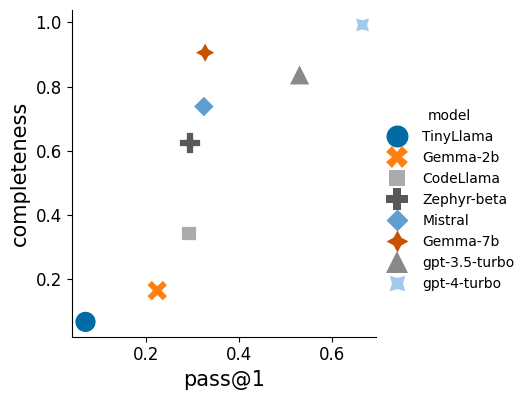

PearsonRResult(statistic=0.8312803082221738, pvalue=0.010538974673184189)
SignificanceResult(statistic=0.9761904761904763, pvalue=3.3143960262001043e-05)
SignificanceResult(statistic=0.9285714285714285, pvalue=0.0003968253968253968)


In [12]:
x, y = "pass@1", "completeness"
ax = sns.relplot(data=table, x=x, y=y, hue="model", 
                 style="model", s=250, height=4, aspect=1)
plt.xlabel(x, fontsize=15)
plt.ylabel(y, fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)


filename = f"images/{repair_task}_accuracy.pdf"
plt.savefig(filename, bbox_inches="tight", dpi=300)
plt.show()

x, y = table[x], table[y]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

### Pass rate against ROUGE

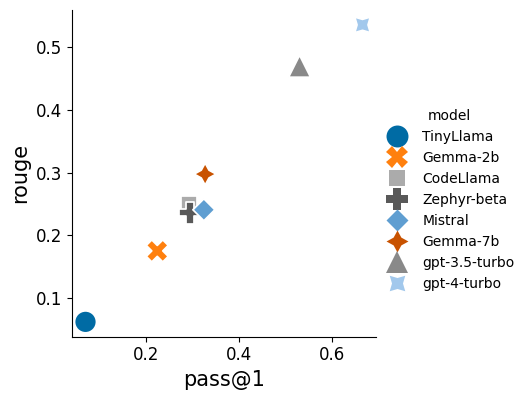

PearsonRResult(statistic=0.9910476590060446, pvalue=1.781678402779879e-06)
SignificanceResult(statistic=0.9285714285714287, pvalue=0.0008629681828999769)
SignificanceResult(statistic=0.8571428571428571, pvalue=0.001736111111111111)


In [13]:
x, y = "pass@1", ROUGE
ax = sns.relplot(data=table, x="pass@1", y=ROUGE, hue="model", 
                 style="model", s=250, height=4, aspect=1)
# Set axes labels with larger font size
plt.xlabel(x, fontsize=15)
plt.ylabel(ROUGE, fontsize=15)
# Adjust the size of the tickz
plt.tick_params(axis='both', which='major', labelsize=12)

#plt.title("Closeness as a function of functional correctness")
filename = f"images/{repair_task}_{ROUGE}.pdf"
plt.savefig(filename, bbox_inches="tight", dpi=300)
plt.show()

x, y = table[x], table[y]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

### Accuracy vs Precision

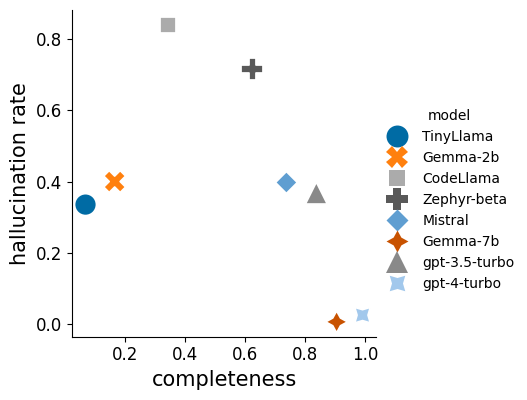

PearsonRResult(statistic=-0.4874497927425214, pvalue=0.22048865104600138)
SignificanceResult(statistic=-0.5476190476190477, pvalue=0.1600256425388966)
SignificanceResult(statistic=-0.42857142857142855, pvalue=0.17886904761904762)


In [14]:
x, y = "completeness", "hallucination rate"

ax = sns.relplot(data=table, x=x, y=y, hue="model", 
                 style="model", s=250, height=4, aspect=1)
#ax._legend.remove()
#sns.move_legend(ax, "best")

plt.xlabel(x, fontsize=15)
plt.ylabel(y, fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)

filename = f"images/{x}_{y}.pdf"
plt.savefig(filename, bbox_inches="tight", dpi=300)
plt.show()

print(scipy.stats.pearsonr(table[x], table[y]))
print(scipy.stats.spearmanr(table[x], table[y]))
print(scipy.stats.kendalltau(table[x], table[y]))

# Decomposing the results based on program concept analysis

Let's look at, for each concept, the scores obtained both for repair and NLE generation

In [15]:
def get_concept_results(config_name, test_run=False):
    all_data = []
    for res, config_identifiers in yield_directories(config_name, test_run):
        
        if "concepts_scores" not in res: continue
        
        for concept_result in res["concepts_scores"]:
            for metric, value in concept_result["scores"].items():
                information = deepcopy(config_identifiers)
                information["concept"] = concept_result["concept"]
                information["n_exercises"] = concept_result["n_exercises"]
                information["n_problems"] = concept_result["n_problems"]
                information["metric"] = metric
                information["values"] = value
                
                all_data.append(information)
        
    return pd.DataFrame(all_data)
        
concepts_results = get_concept_results("bea", False)
concepts_results["metric"] = concepts_results["metric"].apply(lambda a: metric_renaming.get(a, a))
concepts_results

/tmp/ipykernel_13104/786789844.py:18: UserWarning: Experiment llama-7b_repair_falconcode has not finnished yet or failed.
  warn(f"Experiment {config.name} has not finnished yet or failed.")
/tmp/ipykernel_13104/786789844.py:18: UserWarning: Experiment codellama-7b_repair_falconcode has not finnished yet or failed.
  warn(f"Experiment {config.name} has not finnished yet or failed.")
/tmp/ipykernel_13104/786789844.py:18: UserWarning: Experiment gemma-2b_repair_falconcode has not finnished yet or failed.
  warn(f"Experiment {config.name} has not finnished yet or failed.")


,agent,dataset,task,concept,n_exercises,n_problems,metric,values
0,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_str,4,68,completeness,0.852941
1,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_str,4,68,hallucination rate,0.661765
2,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_cast,27,257,completeness,0.649805
3,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_cast,27,257,hallucination rate,0.498054
4,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,output,28,249,completeness,0.610442
...,...,...,...,...,...,...,...,...
4360,google/gemma-2b-it,falconcode,greedy_repair,list,3,38,rouge@1,0.087073
4361,google/gemma-2b-it,falconcode,greedy_repair,list,3,38,rouge,0.087073
4362,google/gemma-2b-it,falconcode,greedy_repair,list_2d,3,17,pass@1,0.470588
4363,google/gemma-2b-it,falconcode,greedy_repair,list_2d,3,17,rouge@1,0.311939


#### Quickly first, let's show the number of exercises practicing each concept

todo if time, create table automatically

In [16]:
concepts_results.groupby(["concept", "task"]).n_exercises.value_counts()

concept          task           n_exercises
assignment       feedback       26              18
                 greedy_repair  26              27
                 repair         26             246
conditional      feedback       22              18
                 greedy_repair  22              27
                 repair         22             246
function_call    feedback       8               18
                 greedy_repair  8               27
                 repair         8              246
function_def     feedback       9               18
                 greedy_repair  9               27
                 repair         9              246
function_return  feedback       6               18
                 greedy_repair  6               27
                 repair         6              246
input_cast       feedback       27              18
                 greedy_repair  27              27
                 repair         27             246
input_str        feedback       4     

In [17]:
concepts_results.groupby(["concept", "task"]).n_problems.value_counts()

concept          task           n_problems
assignment       feedback       217            18
                 greedy_repair  217            27
                 repair         4340          246
conditional      feedback       257            18
                 greedy_repair  257            27
                 repair         5140          246
function_call    feedback       63             18
                 greedy_repair  63             27
                 repair         1260          246
function_def     feedback       65             18
                 greedy_repair  65             27
                 repair         1300          246
function_return  feedback       43             18
                 greedy_repair  43             27
                 repair         860           246
input_cast       feedback       257            18
                 greedy_repair  257            27
                 repair         5140          246
input_str        feedback       68             18
       

In [18]:
concepts_results = concepts_results[concepts_results.n_exercises >= 3]
concepts_results

,agent,dataset,task,concept,n_exercises,n_problems,metric,values
0,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_str,4,68,completeness,0.852941
1,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_str,4,68,hallucination rate,0.661765
2,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_cast,27,257,completeness,0.649805
3,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,input_cast,27,257,hallucination rate,0.498054
4,meta-llama/Llama-2-7b-chat-hf,falconcode,feedback,output,28,249,completeness,0.610442
...,...,...,...,...,...,...,...,...
4360,google/gemma-2b-it,falconcode,greedy_repair,list,3,38,rouge@1,0.087073
4361,google/gemma-2b-it,falconcode,greedy_repair,list,3,38,rouge,0.087073
4362,google/gemma-2b-it,falconcode,greedy_repair,list_2d,3,17,pass@1,0.470588
4363,google/gemma-2b-it,falconcode,greedy_repair,list_2d,3,17,rouge@1,0.311939


### Overview: comparing model performances accross concepts

In [19]:
def create_table(sub_df):
    
    metric = "".join([str(m) for m in sub_df.metric.unique()])
    print(metric)
    
    sub_df = sub_df.pivot_table(
    index=['agent'], columns=["concept"], 
    values='values', aggfunc='mean')

    order = [v for k, v in rename_concepts.items() if k in sub_df.columns]
    sub_df = sub_df.rename(index=agent_to_model)
    sub_df = sub_df.rename(columns=rename_concepts)
    sub_df = sub_df.fillna(0).round(2)
    sub_df = sub_df[order]
    sub_df = sub_df.loc[[m for m in model_order if m in sub_df.index]]
    sub_df.columns.name = ""
    
    # adding the pass rates from the total value
    pass_rate = table[["model", metric]].set_index("model").dropna().round(2)
    #sub_df = pd.concat([sub_df, pass_rate], axis=1)
    
    # adding the average per concept
    average = sub_df.mean(axis=0)
    average.name = "average"
    average = average.to_frame().T.round(2)
    sub_df = pd.concat([sub_df, average], axis=0).dropna()
    
    return sub_df

In [20]:
column_format = "l|ccc|cc|ccc|cc|c|cc"
column_format

'l|ccc|cc|ccc|cc|c|cc'

In [21]:
def find_worst_concepts(sub_df):    
    # Get the column label of the maximum value in each row
    min_column_labels = sub_df.idxmin(axis=1)
    min_column_labels.name = "Worst"
    
    summary = pd.concat([min_column_labels], axis=1)
    summary.name = sub_df.name
    
    return summary

#### Pass rate

In [22]:
sub_df = concepts_results[(concepts_results.task == repair_task) & (concepts_results.metric == "pass@1")]
sub_df = create_table(sub_df)
sub_df.name = "pass@1"
sub_df

pass@1


,IS,IC,O,A,C,FC,FD,FR,LC,LU,SC,L,L2D
TinyLlama,0.04,0.03,0.03,0.07,0.05,0.21,0.09,0.14,0.03,0.03,0.04,0.03,0.06
Gemma-2b,0.06,0.13,0.13,0.12,0.19,0.44,0.60,0.77,0.13,0.05,0.10,0.11,0.47
CodeLlama,0.22,0.18,0.24,0.24,0.26,0.54,0.52,0.56,0.19,0.29,0.21,0.24,0.59
Zephyr-beta,0.10,0.17,0.17,0.24,0.25,0.60,0.58,0.86,0.23,0.26,0.26,0.26,0.41
Mistral,0.13,0.23,0.22,0.27,0.28,0.56,0.49,0.67,0.19,0.24,0.24,0.34,0.65
Gemma-7b,0.16,0.22,0.25,0.29,0.25,0.52,0.52,0.53,0.21,0.47,0.21,0.26,0.47
gpt-3.5-turbo,0.44,0.41,0.50,0.52,0.46,0.84,0.86,0.91,0.49,0.50,0.55,0.68,0.76
gpt-4-turbo,0.21,0.58,0.63,0.64,0.63,0.86,0.92,1.00,0.39,0.50,0.48,0.42,0.76
average,0.17,0.24,0.27,0.30,0.30,0.57,0.57,0.68,0.23,0.29,0.26,0.29,0.52


In [23]:
print(sub_df.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False,
                      column_format=column_format))

\begin{tabular}{l|ccc|cc|ccc|cc|c|cc}
\toprule
 & IS & IC & O & A & C & FC & FD & FR & LC & LU & SC & L & L2D \\
\midrule
TinyLlama & 0.04 & 0.03 & 0.03 & 0.07 & 0.05 & 0.21 & 0.09 & 0.14 & 0.03 & 0.03 & 0.04 & 0.03 & 0.06 \\
Gemma-2b & 0.06 & 0.13 & 0.13 & 0.12 & 0.19 & 0.44 & 0.60 & 0.77 & 0.13 & 0.05 & 0.10 & 0.11 & 0.47 \\
CodeLlama & 0.22 & 0.18 & 0.24 & 0.24 & 0.26 & 0.54 & 0.52 & 0.56 & 0.19 & 0.29 & 0.21 & 0.24 & 0.59 \\
Zephyr-beta & 0.10 & 0.17 & 0.17 & 0.24 & 0.25 & 0.60 & 0.58 & 0.86 & 0.23 & 0.26 & 0.26 & 0.26 & 0.41 \\
Mistral & 0.13 & 0.23 & 0.22 & 0.27 & 0.28 & 0.56 & 0.49 & 0.67 & 0.19 & 0.24 & 0.24 & 0.34 & 0.65 \\
Gemma-7b & 0.16 & 0.22 & 0.25 & 0.29 & 0.25 & 0.52 & 0.52 & 0.53 & 0.21 & 0.47 & 0.21 & 0.26 & 0.47 \\
gpt-3.5-turbo & 0.44 & 0.41 & 0.50 & 0.52 & 0.46 & 0.84 & 0.86 & 0.91 & 0.49 & 0.50 & 0.55 & 0.68 & 0.76 \\
gpt-4-turbo & 0.21 & 0.58 & 0.63 & 0.64 & 0.63 & 0.86 & 0.92 & 1.00 & 0.39 & 0.50 & 0.48 & 0.42 & 0.76 \\
average & 0.17 & 0.24 & 0.27 & 0.30 & 0.30

In [24]:
pr_summary = find_worst_concepts(sub_df)
pr_summary

,Worst
TinyLlama,IC
Gemma-2b,LU
CodeLlama,IC
Zephyr-beta,IS
Mistral,IS
Gemma-7b,IS
gpt-3.5-turbo,IC
gpt-4-turbo,IS
average,IS


In [25]:
print(pr_summary.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False))

\begin{tabular}{ll}
\toprule
 & Worst \\
\midrule
TinyLlama & IC \\
Gemma-2b & LU \\
CodeLlama & IC \\
Zephyr-beta & IS \\
Mistral & IS \\
Gemma-7b & IS \\
gpt-3.5-turbo & IC \\
gpt-4-turbo & IS \\
average & IS \\
\bottomrule
\end{tabular}



#### ROUGE

In [26]:
sub_df = concepts_results[(concepts_results.task == repair_task) & (concepts_results.metric == ROUGE)]
sub_df = create_table(sub_df)
sub_df.name = ROUGE
sub_df

rouge


,IS,IC,O,A,C,FC,FD,FR,LC,LU,SC,L,L2D
TinyLlama,0.04,0.03,0.03,0.07,0.05,0.17,0.08,0.13,0.03,0.03,0.04,0.03,0.06
Gemma-2b,0.05,0.11,0.11,0.11,0.15,0.32,0.45,0.57,0.12,0.05,0.10,0.09,0.31
CodeLlama,0.20,0.15,0.20,0.22,0.21,0.46,0.45,0.47,0.17,0.25,0.18,0.21,0.51
Zephyr-beta,0.07,0.13,0.13,0.20,0.19,0.50,0.48,0.71,0.18,0.21,0.21,0.22,0.32
Mistral,0.08,0.15,0.16,0.20,0.20,0.44,0.38,0.52,0.14,0.15,0.16,0.26,0.48
Gemma-7b,0.16,0.20,0.22,0.28,0.23,0.49,0.47,0.49,0.20,0.43,0.21,0.25,0.44
gpt-3.5-turbo,0.41,0.37,0.44,0.47,0.41,0.74,0.76,0.80,0.45,0.45,0.51,0.63,0.72
gpt-4-turbo,0.17,0.46,0.51,0.52,0.50,0.70,0.72,0.77,0.31,0.40,0.38,0.35,0.61
average,0.15,0.20,0.22,0.26,0.24,0.48,0.47,0.56,0.20,0.25,0.22,0.26,0.43


In [27]:
print(sub_df.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False,
                      column_format=column_format))

\begin{tabular}{l|ccc|cc|ccc|cc|c|cc}
\toprule
 & IS & IC & O & A & C & FC & FD & FR & LC & LU & SC & L & L2D \\
\midrule
TinyLlama & 0.04 & 0.03 & 0.03 & 0.07 & 0.05 & 0.17 & 0.08 & 0.13 & 0.03 & 0.03 & 0.04 & 0.03 & 0.06 \\
Gemma-2b & 0.05 & 0.11 & 0.11 & 0.11 & 0.15 & 0.32 & 0.45 & 0.57 & 0.12 & 0.05 & 0.10 & 0.09 & 0.31 \\
CodeLlama & 0.20 & 0.15 & 0.20 & 0.22 & 0.21 & 0.46 & 0.45 & 0.47 & 0.17 & 0.25 & 0.18 & 0.21 & 0.51 \\
Zephyr-beta & 0.07 & 0.13 & 0.13 & 0.20 & 0.19 & 0.50 & 0.48 & 0.71 & 0.18 & 0.21 & 0.21 & 0.22 & 0.32 \\
Mistral & 0.08 & 0.15 & 0.16 & 0.20 & 0.20 & 0.44 & 0.38 & 0.52 & 0.14 & 0.15 & 0.16 & 0.26 & 0.48 \\
Gemma-7b & 0.16 & 0.20 & 0.22 & 0.28 & 0.23 & 0.49 & 0.47 & 0.49 & 0.20 & 0.43 & 0.21 & 0.25 & 0.44 \\
gpt-3.5-turbo & 0.41 & 0.37 & 0.44 & 0.47 & 0.41 & 0.74 & 0.76 & 0.80 & 0.45 & 0.45 & 0.51 & 0.63 & 0.72 \\
gpt-4-turbo & 0.17 & 0.46 & 0.51 & 0.52 & 0.50 & 0.70 & 0.72 & 0.77 & 0.31 & 0.40 & 0.38 & 0.35 & 0.61 \\
average & 0.15 & 0.20 & 0.22 & 0.26 & 0.24

In [28]:
rg_summary = find_worst_concepts(sub_df)
rg_summary

,Worst
TinyLlama,IC
Gemma-2b,IS
CodeLlama,IC
Zephyr-beta,IS
Mistral,IS
Gemma-7b,IS
gpt-3.5-turbo,IC
gpt-4-turbo,IS
average,IS


In [29]:
print(rg_summary.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False))

\begin{tabular}{ll}
\toprule
 & Worst \\
\midrule
TinyLlama & IC \\
Gemma-2b & IS \\
CodeLlama & IC \\
Zephyr-beta & IS \\
Mistral & IS \\
Gemma-7b & IS \\
gpt-3.5-turbo & IC \\
gpt-4-turbo & IS \\
average & IS \\
\bottomrule
\end{tabular}



#### Accuracy

In [30]:
sub_df = concepts_results[(concepts_results.task == "feedback") & (concepts_results.metric == "completeness")]
sub_df = create_table(sub_df)
sub_df.name = "completeness"
sub_df

completeness


,IS,IC,O,A,C,FC,FD,FR,LC,LU,SC,L,L2D
TinyLlama,0.04,0.07,0.07,0.04,0.08,0.03,0.08,0.07,0.04,0.00,0.05,0.08,0.18
Gemma-2b,0.15,0.15,0.14,0.17,0.15,0.21,0.20,0.26,0.16,0.05,0.17,0.18,0.06
CodeLlama,0.31,0.33,0.32,0.37,0.35,0.43,0.35,0.35,0.33,0.45,0.42,0.26,0.24
Zephyr-beta,0.54,0.64,0.65,0.59,0.63,0.60,0.51,0.51,0.55,0.71,0.60,0.76,0.59
Mistral,0.81,0.74,0.71,0.77,0.75,0.79,0.69,0.79,0.73,0.76,0.79,0.79,0.82
Gemma-7b,0.94,0.94,0.92,0.91,0.95,0.76,0.86,0.91,0.90,1.00,0.94,0.95,1.00
gpt-3.5-turbo,0.93,0.82,0.82,0.87,0.84,0.84,0.86,0.81,0.83,0.76,0.89,0.97,0.94
gpt-4-turbo,1.00,0.99,0.99,1.00,0.99,0.98,0.98,0.98,0.99,0.97,1.00,1.00,1.00
average,0.59,0.58,0.58,0.59,0.59,0.58,0.57,0.58,0.57,0.59,0.61,0.62,0.60


In [31]:
print(sub_df.to_latex(multirow=True, multicolumn=True, longtable=False, index_names=False, index=True,
                  float_format="%.2f", escape=True, multicolumn_format='c', 
                      column_format=column_format,
                      bold_rows=False))

\begin{tabular}{l|ccc|cc|ccc|cc|c|cc}
\toprule
 & IS & IC & O & A & C & FC & FD & FR & LC & LU & SC & L & L2D \\
\midrule
TinyLlama & 0.04 & 0.07 & 0.07 & 0.04 & 0.08 & 0.03 & 0.08 & 0.07 & 0.04 & 0.00 & 0.05 & 0.08 & 0.18 \\
Gemma-2b & 0.15 & 0.15 & 0.14 & 0.17 & 0.15 & 0.21 & 0.20 & 0.26 & 0.16 & 0.05 & 0.17 & 0.18 & 0.06 \\
CodeLlama & 0.31 & 0.33 & 0.32 & 0.37 & 0.35 & 0.43 & 0.35 & 0.35 & 0.33 & 0.45 & 0.42 & 0.26 & 0.24 \\
Zephyr-beta & 0.54 & 0.64 & 0.65 & 0.59 & 0.63 & 0.60 & 0.51 & 0.51 & 0.55 & 0.71 & 0.60 & 0.76 & 0.59 \\
Mistral & 0.81 & 0.74 & 0.71 & 0.77 & 0.75 & 0.79 & 0.69 & 0.79 & 0.73 & 0.76 & 0.79 & 0.79 & 0.82 \\
Gemma-7b & 0.94 & 0.94 & 0.92 & 0.91 & 0.95 & 0.76 & 0.86 & 0.91 & 0.90 & 1.00 & 0.94 & 0.95 & 1.00 \\
gpt-3.5-turbo & 0.93 & 0.82 & 0.82 & 0.87 & 0.84 & 0.84 & 0.86 & 0.81 & 0.83 & 0.76 & 0.89 & 0.97 & 0.94 \\
gpt-4-turbo & 1.00 & 0.99 & 0.99 & 1.00 & 0.99 & 0.98 & 0.98 & 0.98 & 0.99 & 0.97 & 1.00 & 1.00 & 1.00 \\
average & 0.59 & 0.58 & 0.58 & 0.59 & 0.59

In [32]:
acc_summary = find_worst_concepts(sub_df)
acc_summary

,Worst
TinyLlama,LU
Gemma-2b,LU
CodeLlama,L2D
Zephyr-beta,FD
Mistral,FD
Gemma-7b,FC
gpt-3.5-turbo,LU
gpt-4-turbo,LU
average,FD


In [33]:
print(acc_summary.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False))

\begin{tabular}{ll}
\toprule
 & Worst \\
\midrule
TinyLlama & LU \\
Gemma-2b & LU \\
CodeLlama & L2D \\
Zephyr-beta & FD \\
Mistral & FD \\
Gemma-7b & FC \\
gpt-3.5-turbo & LU \\
gpt-4-turbo & LU \\
average & FD \\
\bottomrule
\end{tabular}



#### Precision

In [106]:
sub_df = concepts_results[(concepts_results.task == "feedback") & (concepts_results.metric == "hallucination rate")]
sub_df.loc[:, "values"] = 1 - sub_df.loc[:, "values"] # need to do that to have proper assignment for concept results
sub_df = create_table(sub_df)
sub_df.name = "hallucination rate"
sub_df

hallucination rate


,IS,IC,O,A,C,FC,FD,FR,LC,LU,SC,L,L2D
TinyLlama,0.47,0.30,0.25,0.35,0.31,0.41,0.42,0.40,0.43,0.21,0.40,0.39,0.18
Gemma-2b,0.12,0.37,0.42,0.37,0.35,0.32,0.48,0.40,0.24,0.55,0.28,0.13,0.65
CodeLlama,0.87,0.86,0.87,0.82,0.85,0.75,0.82,0.81,0.82,0.89,0.80,0.97,0.88
Zephyr-beta,0.88,0.79,0.78,0.80,0.78,0.46,0.60,0.49,0.86,0.61,0.89,0.87,0.65
Mistral,0.43,0.42,0.42,0.39,0.41,0.32,0.32,0.35,0.41,0.32,0.37,0.45,0.41
Gemma-7b,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.03,0.02,0.00,0.00
gpt-3.5-turbo,0.28,0.31,0.35,0.36,0.35,0.54,0.49,0.51,0.34,0.21,0.29,0.24,0.24
gpt-4-turbo,0.00,0.02,0.02,0.02,0.02,0.00,0.03,0.05,0.00,0.05,0.01,0.05,0.06
average,0.38,0.38,0.39,0.39,0.38,0.35,0.40,0.38,0.39,0.36,0.38,0.39,0.38


In [107]:
print(sub_df.to_latex(multirow=True, multicolumn=True, longtable=False, index_names=False, index=True,
                  float_format="%.2f", escape=True, multicolumn_format='c', 
                      column_format=column_format,
                      bold_rows=False))

\begin{tabular}{l|ccc|cc|ccc|cc|c|cc}
\toprule
 & IS & IC & O & A & C & FC & FD & FR & LC & LU & SC & L & L2D \\
\midrule
TinyLlama & 0.47 & 0.30 & 0.25 & 0.35 & 0.31 & 0.41 & 0.42 & 0.40 & 0.43 & 0.21 & 0.40 & 0.39 & 0.18 \\
Gemma-2b & 0.12 & 0.37 & 0.42 & 0.37 & 0.35 & 0.32 & 0.48 & 0.40 & 0.24 & 0.55 & 0.28 & 0.13 & 0.65 \\
CodeLlama & 0.87 & 0.86 & 0.87 & 0.82 & 0.85 & 0.75 & 0.82 & 0.81 & 0.82 & 0.89 & 0.80 & 0.97 & 0.88 \\
Zephyr-beta & 0.88 & 0.79 & 0.78 & 0.80 & 0.78 & 0.46 & 0.60 & 0.49 & 0.86 & 0.61 & 0.89 & 0.87 & 0.65 \\
Mistral & 0.43 & 0.42 & 0.42 & 0.39 & 0.41 & 0.32 & 0.32 & 0.35 & 0.41 & 0.32 & 0.37 & 0.45 & 0.41 \\
Gemma-7b & 0.00 & 0.01 & 0.01 & 0.01 & 0.01 & 0.00 & 0.00 & 0.00 & 0.01 & 0.03 & 0.02 & 0.00 & 0.00 \\
gpt-3.5-turbo & 0.28 & 0.31 & 0.35 & 0.36 & 0.35 & 0.54 & 0.49 & 0.51 & 0.34 & 0.21 & 0.29 & 0.24 & 0.24 \\
gpt-4-turbo & 0.00 & 0.02 & 0.02 & 0.02 & 0.02 & 0.00 & 0.03 & 0.05 & 0.00 & 0.05 & 0.01 & 0.05 & 0.06 \\
average & 0.38 & 0.38 & 0.39 & 0.39 & 0.38

In [108]:
sub_df.name

'hallucination rate'

In [109]:
sub_df = 1 - sub_df
sub_df.name = "hallucination rate"
prec_summary = find_worst_concepts(sub_df)
prec_summary

,Worst
TinyLlama,IS
Gemma-2b,L2D
CodeLlama,L
Zephyr-beta,SC
Mistral,L
Gemma-7b,LU
gpt-3.5-turbo,FC
gpt-4-turbo,L2D
average,FD


In [88]:
print(pr_summary.to_latex(multirow=True, multicolumn=True, longtable=False, 
                      index_names=False, index=True, float_format="%.2f", 
                      escape=True, multicolumn_format='c', bold_rows=False))

\begin{tabular}{ll}
\toprule
 & Worst \\
\midrule
TinyLlama & IC \\
Gemma-2b & LU \\
CodeLlama & IC \\
Zephyr-beta & IS \\
Mistral & IS \\
Gemma-7b & IS \\
gpt-3.5-turbo & IC \\
gpt-4-turbo & IS \\
average & IS \\
\bottomrule
\end{tabular}



In [61]:
frames = [pr_summary, rg_summary, acc_summary, prec_summary]
merged_df = pd.concat(frames, axis=1)
merged_df.columns = [f.name for f in frames]
merged_df.index.name = "model"
merged_df

,pass@1,rouge,completeness,hallucination rate
model,,,,
TinyLlama,IC,IC,LU,IS
Gemma-2b,LU,IS,LU,L2D
CodeLlama,IC,IC,L2D,L
Zephyr-beta,IS,IS,FD,SC
Mistral,IS,IS,FD,L
Gemma-7b,IS,IS,FC,LU
gpt-3.5-turbo,IC,IC,LU,FC
gpt-4-turbo,IS,IS,LU,L2D
average,IS,IS,FD,FD


In [62]:
print(merged_df.to_latex(multirow=True, multicolumn=True, index=True, index_names=False, 
                    escape=True, bold_rows=False, column_format='l|cc|cc'))

\begin{tabular}{l|cc|cc}
\toprule
 & pass@1 & rouge & completeness & hallucination rate \\
\midrule
TinyLlama & IC & IC & LU & IS \\
Gemma-2b & LU & IS & LU & L2D \\
CodeLlama & IC & IC & L2D & L \\
Zephyr-beta & IS & IS & FD & SC \\
Mistral & IS & IS & FD & L \\
Gemma-7b & IS & IS & FC & LU \\
gpt-3.5-turbo & IC & IC & LU & FC \\
gpt-4-turbo & IS & IS & LU & L2D \\
average & IS & IS & FD & FD \\
\bottomrule
\end{tabular}

